In [1]:
import numpy as np
import configparser
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import io


#from google.colab import files
#uploaded = files.upload()

In [2]:
raw_channel = np.load('/users/emilyzeng/Downloads/raw_cortex.npy')
anno_channel = np.load('/users/emilyzeng/Downloads/anno_cortex.npy')
print(raw_channel.shape)
print(anno_channel.shape)


(300, 300, 300)
(300, 300, 300)


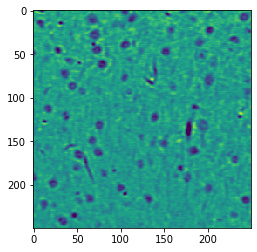

In [3]:

# Divide the data into training, test (don't change this!)
x_train = raw_channel[0:250,0:250,0:100]
x_test = raw_channel[0:250,0:250,100:150]
y_train = anno_channel[0:250,0:250,0:100]
#Cell bodies are indicated with the annotation 2, convert this so y_train=1 is a cell and y_train=0 is not a cell
y_train[y_train>2]=0
y_train[y_train<2]=0
y_train[y_train==2]=1

#Cell bodies are indicated with the annotation 2, convert this so y_test=1 is a cell and y_test=0 is not a cell
y_test = anno_channel[0:250,0:250,100:150]
y_test[y_test>2]=0
y_test[y_test<2]=0
y_test[y_test==2]=1
#display images
plt.imshow(np.squeeze(x_train[:,:,50]))

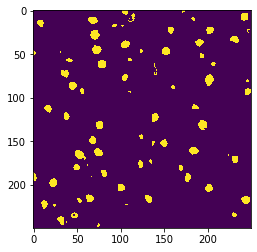

In [4]:
#show labels
plt.imshow(np.squeeze(y_train[:,:,50]))

In [5]:
#a bad threshold detector for cells- we can do better!
def bad_detector(x_data, parameters):
  y_hat = (x_data<parameters['threshold']).astype(int)
  return y_hat

#compute the f1 metric to tell how good something is
def f1_score(y_true,y_hat,threshold=0.5):
  y_true[y_true>threshold] = 1
  y_true[y_true<threshold] = 0
  y_hat[y_hat>threshold] = 1
  y_hat[y_hat<threshold] = 0
  
  #https://en.wikipedia.org/wiki/F1_score
  y_and = np.add(y_true,y_hat)
  true_detections = len(np.where(y_and>1)[0])#add the two numbers together, if both are true it will be 2
  detect_positives = len(np.where(y_hat>0)[0]) #positive numbers indicate detections
  true_positives = len(np.where(y_true>0)[0]) #posiive numbers indicate true cells
  precision = true_detections/detect_positives
  recall = true_detections/true_positives
  f1 = 2*precision*recall/(precision+recall)
  return f1

In [56]:
#This is the bad baseline you need to beat!
y_hat = bad_detector(x_test,{"threshold":80})
f1 = f1_score(y_test,y_hat,threshold=0.5)
print(f'f1 score for bad detector is {f1}. Try to do better!')

f1 score for bad detector is 0.7557119354154758. Try to do better!


In [7]:
#YOUR CODE HERE
#Print sizes of xtrain, ytrain, xtest, ytest
print("xtrain: " + str(x_train.shape))
print("ytrain: " + str(y_train.shape))
print("xtest: " + str(x_test.shape))
print("ytest: " + str(y_test.shape))

#Find maximum and minumum values of xtrain, ytrain, xtest, ytest
data_list = [x_train, y_train, x_test, y_test]
names_list = ["xtrain", "ytrain", "xtest", "ytest"]
max_values = []
min_values = []
#iterates through the data for each of the data sets
for data in data_list:
    maximum = data[0][0][0]
    minimum = data[0][0][0]
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                if data[i][j][k] > maximum:
                    maximum = data[i][j][k]
                if data[i][j][k] < minimum:
                    minimum = data[i][j][k]
    #saves max and min values of each data set to the corresponding list
    max_values.append(maximum)
    min_values.append(minimum)

#prints out maximum and minimum values
print()
for i in range(len(data_list)):
    print(names_list[i] + " - Max: " + str(max_values[i]) + " Min: " + str(min_values[i])) 

xtrain: (250, 250, 100)
ytrain: (250, 250, 100)
xtest: (250, 250, 50)
ytest: (250, 250, 50)

xtrain - Max: 255 Min: 0
ytrain - Max: 1 Min: 0
xtest - Max: 255 Min: 0
ytest - Max: 1 Min: 0


In [58]:
#YOUR CODE HERE
#Select or train parameters for your classifier using only xtrain, ytrain
conv_kernel = np.array([[[-1, -1, -1], [-1, -1, -1], [-1, -1, -1]],
                        [[-1, -1, -1], [-1, 30, -1], [-1, -1, -1]],
                        [[-1, -1, -1], [-1, -1, -1], [-1, -1, -1]]]) 
def convert(kernel, image_patch):
    num = 0
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            for k in range(kernel.shape[2]):
                num += kernel[i][j][k] * image_patch[i][j][k]
    return num

#takes in kernel and entire image data and applys kernel over entire image
#uses convert function
#returns result matrix
def convert_image(kernel, image, offset):
    # This initializes the result matrix with zero
    result = []
    values = []
    dim1 = image.shape[0] - kernel.shape[0] + 1
    dim2 = image.shape[1] - kernel.shape[1] + 1
    dim3 = image.shape[2] - kernel.shape[2] + 1
    temp = np.zeros((kernel.shape[0], kernel.shape[1], kernel.shape[2]))
    
    for a in range(81):
        for b in range(81):
            for c in range(50):
                #creates image patch
                for d in range(kernel.shape[0]):
                    for e in range(kernel.shape[1]):
                        for f in range(kernel.shape[2]):
                            temp[d][e][f] = image[a+d+offset][b+e+offset][c+f]
                number = convert(kernel, temp)
                #values.append(number)
                if number > 0:
                    result.append((a+d, b+e, c+f))
    #print(values)
    return result

    
#print(x_train[2][18][16])
coordinates1 = convert_image(conv_kernel, y_train, 0)
coordinates2 = convert_image(conv_kernel, y_train, 81)
coordinates3 = convert_image(conv_kernel, y_train, 162)
total_length = len(coordinates1) + len(coordinates2) + len(coordinates3)

total1 = 0
total2 = 0
#total3 = 0
for i in range(len(coordinates1)):
    coor1 = coordinates1[i]
    coor2 = coordinates2[i]
    coor3 = coordinates3[i]
    total1 += x_train[coor1[0]][coor1[1]][coor1[2]]
    total2 += x_train[coor2[0]][coor2[1]][coor2[2]] 
    #total3 += x_train[coor3[0]][coor3[1]][coor3[2]]

print((total1+total2)/total_length)



82.46057695702835


In [9]:
#YOUR CODE HERE
#run your parameters for your classifier to produce y_hat using only your parameters and x_test

In [10]:
#YOUR CODE HERE
#use the f1_score function using your y_hat and y_test
f1 = f1_score(y_test,y_hat,threshold=0.5)
#print f1 score
print("f1 score: " + str(f1))

f1 score: 0.2463732451632625


In [11]:
#YOUR CODE HERE
#Plot an example of your y_hat and y_test